# Ingestion

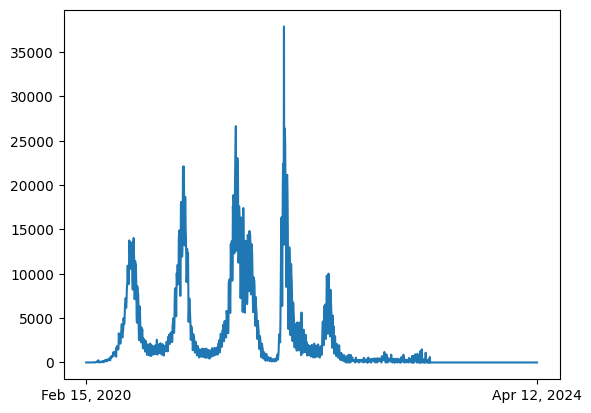

In [3]:
from bs4 import BeautifulSoup
import requests
import re
import json
import matplotlib.pyplot as plt
import pandas as pd

soup                = BeautifulSoup(requests.get("https://www.worldometers.info/coronavirus/country/south-africa/").content, "html.parser")
graph_cases_daily   = soup.find("script", string=lambda t: 'Highcharts' and 'graph-cases-daily' in t if t else False).get_text()
# Extraction of dates data
dates_regex = re.compile(r"xAxis:\s*{\s*categories:\s*(\[[^\]]+\])")
dates_matched = dates_regex.search(graph_cases_daily)
dates = json.loads(dates_matched.group(1)) if dates_matched else []

# Extraction of daily cases
daily_cases_pattern = re.compile(r"series:\s*\[\s*{[^}]*name:\s*'Daily Cases'[^}]*data:\s*(\[[^\]]+\])")
daily_cases_match = daily_cases_pattern.search(graph_cases_daily)

# Cleaning data

daily_cases_data = json.loads(daily_cases_match.group(1)) if daily_cases_match else []
daily_cases_data = [0 if case == None else case for case in daily_cases_data]

# Create a DataFrame from the two arrays
data = pd.DataFrame({
    'date': pd.to_datetime(dates),
    'cases': daily_cases_data
})

# Set the 'date' column as the index
data.set_index('date', inplace=True)
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

plt.plot(dates, daily_cases_data)
plt.xticks([0, len(dates) - 1], [dates[0], dates[-1]])
plt.show()

# Modelling

In [4]:
# Testing for stationarity
from statsmodels.tsa.stattools import adfuller

print(data['cases'])
adf_test = adfuller(data['cases'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

date
2020-02-15    0
2020-02-16    0
2020-02-17    0
2020-02-18    0
2020-02-19    0
             ..
2024-04-08    0
2024-04-09    0
2024-04-10    0
2024-04-11    0
2024-04-12    0
Freq: D, Name: cases, Length: 1519, dtype: int64
ADF Statistic: -3.881124
p-value: 0.002178


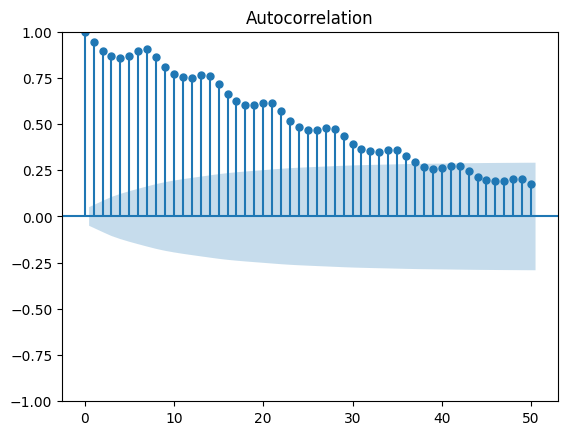

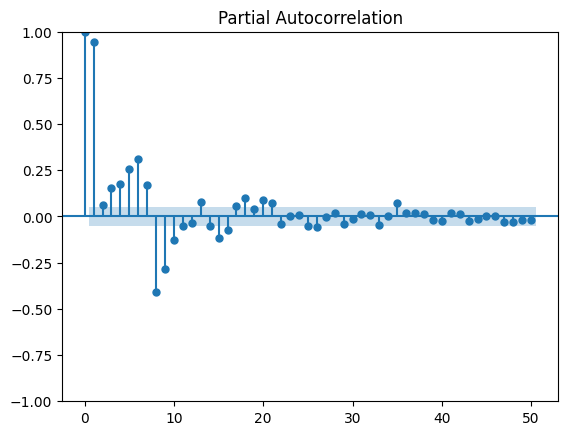

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Test for the differencing term
plot_acf(data['cases'], lags=50) 
plot_pacf(data['cases'], lags=50)
plt.show()

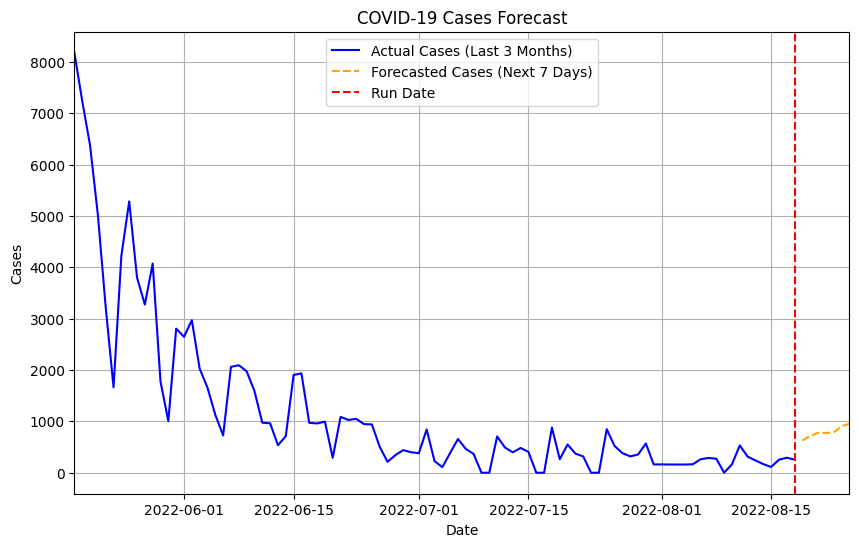


7-Day Forecast Table:
      Date  Projected Cases
2022-08-19       627.257974
2022-08-20       717.702128
2022-08-21       775.591519
2022-08-22       774.427753
2022-08-23       785.456572
2022-08-24       904.514767
2022-08-25       953.074896


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Define the run date
run_date = pd.Timestamp('2022-08-18')

# Split the data into train and test
index_location = data.index.get_loc(run_date)
train_size = int(index_location + 1)
train = data.iloc[0:index_location]

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train['cases'], order=(1, 0, 7))
model_train_fit = model_train.fit()

# Forecast on the test dataset (7-day forecast)
forecast = model_train_fit.get_forecast(steps=7)
predicted_mean = forecast.predicted_mean

# Create a DataFrame for the forecasted values
forecast_dates = pd.date_range(start=run_date + pd.Timedelta(days=1), periods=7)
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Projected Cases': predicted_mean})

# Define the date range to plot (3 months before the run date)
start_date = run_date - pd.DateOffset(months=3)
end_date = forecast_df['Date'].iloc[-1]  # Last date in the forecast

# Filter the data for the 3 months before the run date
plot_data = data[(data.index >= start_date) & (data.index <= run_date)]

# Plotting the forecast alongside the actual data
plt.figure(figsize=(10, 6))
plt.plot(plot_data.index, plot_data['cases'], label='Actual Cases (Last 3 Months)', color='blue')
plt.plot(forecast_df['Date'], forecast_df['Projected Cases'], label='Forecasted Cases (Next 7 Days)', color='orange', linestyle='--')
plt.axvline(x=run_date, color='red', linestyle='--', label='Run Date')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('COVID-19 Cases Forecast')
plt.legend()
plt.grid(True)
plt.xlim([start_date, end_date])  # Set x-axis limits to focus on the desired range
plt.show()

# Print the forecast table
print("\n7-Day Forecast Table:")
print(forecast_df.to_string(index=False))